In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KernelDensity

In [4]:
def read_field_from_file(filename):
    (rank, nbits, num_halo, nx, ny, nz) = np.fromfile(filename, dtype=np.int32, count=6)
    if rank != 3:
        raise NotImplementedError
    offset = (3 + rank) * 32 // nbits
    field = np.fromfile(filename, dtype=np.float32 if nbits == 32 else np.float64,
                        count=nz * ny * nx + offset)
    field = np.reshape(field[offset:], (nz, ny, nx))
    return field

In [5]:
def validate_field(field, reference, rtol=1.e-5, atol=1.e-8):
    check = np.allclose(field, reference, rtol=rtol, atol=atol)
    if not check:
        raise RuntimeError('validation has failed')
    else:
        print('validation was successful')

### Test implementations
Compare all implementations agains the openacc implementation to confirm that everything is working as it should.

In [9]:
%%bash
ml -s nvhpc/23.3-gcc-11.3.0-fcnp4cv openmpi/4.1.5-nvhpc-23.3-xxqowc2 cuda11.7
make -C code clean all

NX=128
NY=128
NZ=64
IT=1024

./code/stencil2d-openacc --nx $NX --ny $NY --nz $NZ --num_iter $IT > /dev/null
mv ./in_field.dat ./data/in_field_ref.dat
mv ./out_field.dat ./data/out_field_ref.dat

./code/stencil2d-cuda --nx $NX --ny $NY --nz $NZ --num_iter $IT > /dev/null
mv ./in_field.dat ./data/in_field_cuda.dat
mv ./out_field.dat ./data/out_field_cuda.dat

./code/stencil2d-cuda-double --nx $NX --ny $NY --nz $NZ --num_iter $IT > /dev/null
mv ./in_field.dat ./data/in_field_cuda_double.dat
mv ./out_field.dat ./data/out_field_cuda_double.dat

./code/stencil2d-cuda-thread-halo --nx $NX --ny $NY --nz $NZ --num_iter $IT > /dev/null
mv ./in_field.dat ./data/in_field_cuda_thread_halo.dat
mv ./out_field.dat ./data/out_field_cuda_thread_halo.dat

./code/stencil2d-cuda-reduce-arrays --nx $NX --ny $NY --nz $NZ --num_iter $IT > /dev/null
mv ./in_field.dat ./data/in_field_cuda_reduce_arrays.dat
mv ./out_field.dat ./data/out_field_cuda_reduce_arrays.dat

./code/stencil2d-cuda-merge-kernels --nx $NX --ny $NY --nz $NZ --num_iter $IT > /dev/null
mv ./in_field.dat ./data/in_field_cuda_merge_kernels.dat
mv ./out_field.dat ./data/out_field_cuda_merge_kernels.dat

./code/stencil2d-cuda-basic --nx $NX --ny $NY --nz $NZ --num_iter $IT > /dev/null
mv ./in_field.dat ./data/in_field_cuda_basic.dat
mv ./out_field.dat ./data/out_field_cuda_basic.dat

make: Entering directory '/home/fhoerold/mpc4wc/plots/code'
rm -f -rf *~ *.o *.mod       \
stencil2d-openacc            \
        stencil2d-cuda               \
        stencil2d-cuda-double        \
        stencil2d-cuda-thread-halo   \
        stencil2d-cuda-reduce-arrays \
        stencil2d-cuda-merge-kernels \
        stencil2d-cuda-basic
mpif90 -O3 -Wl,-z,noexecstack -acc -Mbackslash m_utils.F90 stencil2d_openacc.F90 -o stencil2d-openacc


m_utils.F90:
stencil2d_openacc.F90:


nvcc -O3 stencil2d.cu utils.cpp -o stencil2d-cuda
nvcc -O3 stencil2d-double.cu utils-double.cpp -o stencil2d-cuda-double
nvcc -O3 stencil2d-thread-halo.cu utils.cpp -o stencil2d-cuda-thread-halo
nvcc -O3 stencil2d-reduce-arrays.cu utils.cpp -o stencil2d-cuda-reduce-arrays
nvcc -O3 stencil2d-merge-kernels.cu utils.cpp -o stencil2d-cuda-merge-kernels
nvcc -O3 stencil2d-basic.cu utils.cpp -o stencil2d-cuda-basic
make: Leaving directory '/home/fhoerold/mpc4wc/plots/code'


In [10]:
in_ref = read_field_from_file('./data/in_field_ref.dat')
out_ref = read_field_from_file('./data/out_field_ref.dat')

for s in ('cuda', 'cuda_double', 'cuda_thread_halo', 'cuda_reduce_arrays', 'cuda_merge_kernels', 'cuda_basic'):
    in_test = read_field_from_file('./data/in_field_' + s + '.dat')
    out_test = read_field_from_file('./data/out_field_' + s + '.dat')
    print(s + ':')
    validate_field (in_test[16], in_ref[16], atol=1.e-7)
    validate_field (out_test[16], out_ref[16], atol=1.e-7)
    print()

cuda:
validation was successful
validation was successful

cuda_double:
validation was successful
validation was successful

cuda_thread_halo:
validation was successful
validation was successful

cuda_reduce_arrays:
validation was successful
validation was successful

cuda_merge_kernels:
validation was successful
validation was successful

cuda_basic:
validation was successful
validation was successful



### Set pyplot font sizes

In [18]:
# https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Timing and diffusion plots
Run the optimized cuda kernel a number of times and plot a histogram of the results. Also plot the input and output fields for illustrate the fourth-order diffusion.

In [12]:
%%bash
ml nvhpc/23.3-gcc-11.3.0-fcnp4cv cuda11.7
CUFLAGS="-DWARMUP_REPEATS=0 -DTIMING_REPEATS=100" make -C code clean stencil2d-cuda

./code/stencil2d-cuda --nx 128 --ny 128 --nz 64 --num_iter 1024 > /dev/null
mv ./timing.dat ./data/timing_cuda.dat
mv ./in_field.dat ./data/in_field_cuda.dat
mv ./out_field.dat ./data/out_field_cuda.dat

make: Entering directory '/home/fhoerold/mpc4wc/plots/code'
rm -f -rf *~ *.o *.mod       \
stencil2d-openacc            \
        stencil2d-cuda               \
        stencil2d-cuda-double        \
        stencil2d-cuda-thread-halo   \
        stencil2d-cuda-reduce-arrays \
        stencil2d-cuda-merge-kernels \
        stencil2d-cuda-basic
nvcc -DWARMUP_REPEATS=0 -DTIMING_REPEATS=100 -O3 stencil2d.cu utils.cpp -o stencil2d-cuda
make: Leaving directory '/home/fhoerold/mpc4wc/plots/code'


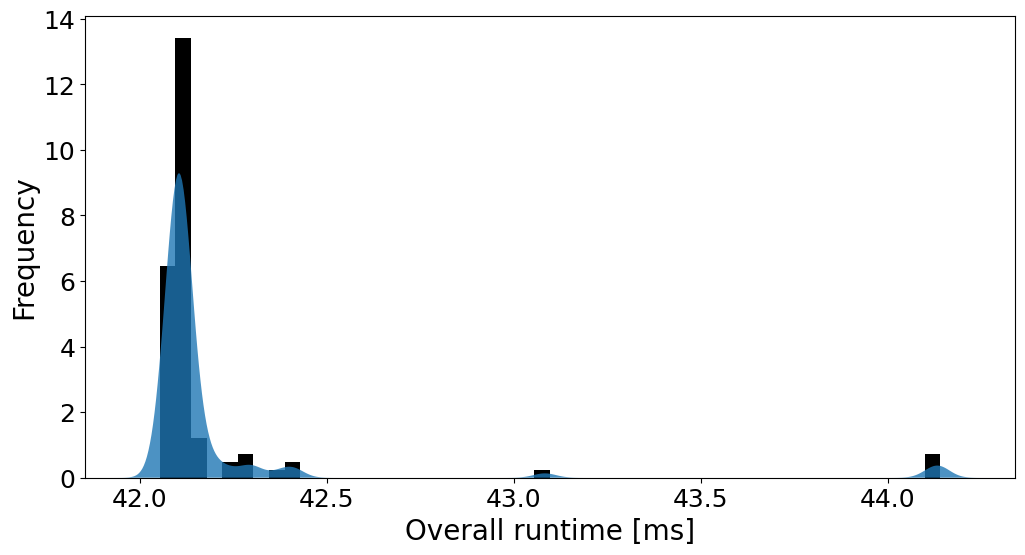

In [13]:
timing = pd.read_csv('./data/timing_cuda.dat')
msecs = np.array(timing.msecs)

timing_range = np.linspace(msecs.min() - 1, msecs.max() + 1, 1000)
kde = KernelDensity(kernel="gaussian", bandwidth=0.03).fit(msecs.reshape(-1, 1))
log_dens = kde.score_samples(timing_range.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(12,6))
ax.hist(msecs, 50, density=True, color='black')
ax.fill(timing_range, np.exp(log_dens), alpha=0.8)
ax.set_xlim([msecs.min() - 0.2, msecs.max() + 0.2])
ax.set_ylim([0.0, ax.get_ylim()[1]])

ax.set_xlabel('Overall runtime [ms]')
ax.set_ylabel('Frequency')
#ax.set_title('Runtime distribution')

plt.savefig('timing.png', bbox_inches='tight')

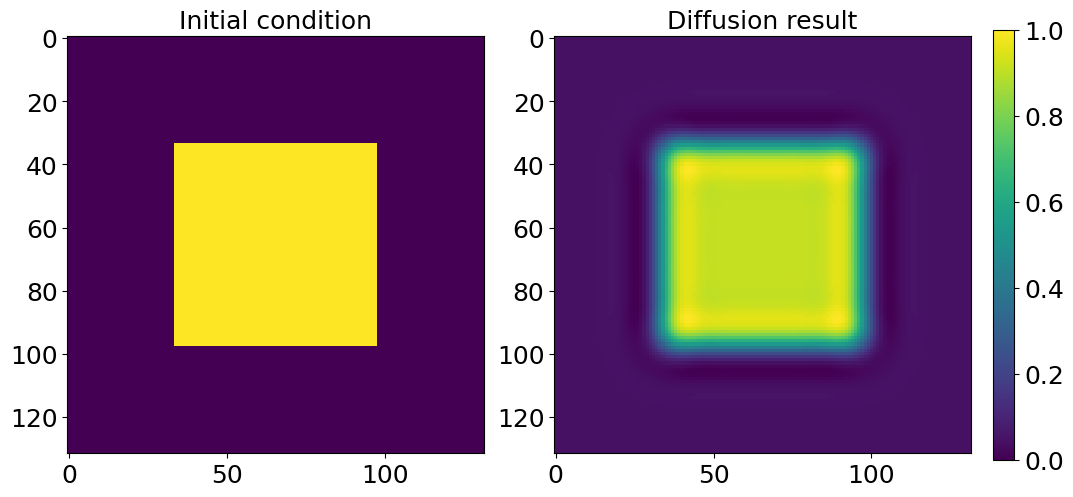

In [14]:
in_cuda = read_field_from_file('./data/in_field_cuda.dat')
out_cuda = read_field_from_file('./data/out_field_cuda.dat')

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
im0 = axs[0].imshow(in_cuda[16])
im1 = axs[1].imshow(out_cuda[16])
axs[0].set_title('Initial condition')
axs[1].set_title('Diffusion result')
fig.tight_layout()
fig.colorbar(im0, ax = axs, shrink=0.82, pad=0.02)

plt.savefig('diffusion.png', bbox_inches='tight')

### Scatter plot helper functions

In [6]:
def read_benchmark_file(filename) -> pd.DataFrame:
    with open(filename, mode='r', encoding='utf-8') as file:
        contents = file.read()
    return eval(contents)

In [7]:
def get_runtime_per_gridpoint(bench):
    rt_ms = bench['time'] / (bench['x'] * bench['y'] * bench['z'])
    rt_us = 1e3 * rt_ms
    return rt_us

In [8]:
def get_gridsize(bench):
    gridsize = bench['x'] * bench['y'] * bench['z']
    return gridsize

In [9]:
def get_workingset(bench, bytes_per_value, num_fields):
    gs_B = num_fields * bytes_per_value * bench['x'] * bench['y'] * bench['z']
    gs_MiB = gs_B / 1024 / 1024
    return gs_MiB

In [10]:
def add_derived_measures(bench, bytes_per_value=4):
    bench['rt_per_gp'] = get_runtime_per_gridpoint(bench)
    bench['gridsize'] = get_gridsize(bench)
    bench['workingset'] = get_workingset(bench, bytes_per_value=bytes_per_value, num_fields=2)

### Optimized plot
Run a scan of the OpenACC code and the optimized code and plot them.

In [11]:
%%bash
ml -s openmpi/4.1.5-nvhpc-23.3-xxqowc2 cuda11.7
make -C code clean stencil2d-openacc

./code/stencil2d-openacc --scan --nz 64 --num_iter 128 | grep -v ranks | sed 's/data = np.array(/pd.DataFrame(columns=["x","y","z","iter","time"], data =/' > ./data/bench_openacc.txt

make: Entering directory '/home/fhoerold/mpc4wc/plots/code'
rm -f -rf *~ *.o *.mod       \
stencil2d-openacc            \
        stencil2d-cuda               \
        stencil2d-cuda-double        \
        stencil2d-cuda-thread-halo   \
        stencil2d-cuda-reduce-arrays \
        stencil2d-cuda-merge-kernels \
        stencil2d-cuda-basic
mpif90 -O3 -Wl,-z,noexecstack -acc -Mbackslash m_utils.F90 stencil2d_openacc.F90 -o stencil2d-openacc


m_utils.F90:
stencil2d_openacc.F90:


make: Leaving directory '/home/fhoerold/mpc4wc/plots/code'


In [12]:
%%bash
ml -s nvhpc/23.3-gcc-11.3.0-fcnp4cv cuda11.7

CUFLAGS=-DTHREADS=8 make -C code clean stencil2d-cuda
./code/stencil2d-cuda --scan --nz 64 --num_iter 128 | grep -v ranks | sed 's/data = np.array(/pd.DataFrame(columns=["x","y","z","iter","time"], data =/' > ./data/bench_cuda08.txt
CUFLAGS=-DTHREADS=16 make -C code clean stencil2d-cuda
./code/stencil2d-cuda --scan --nz 64 --num_iter 128 | grep -v ranks | sed 's/data = np.array(/pd.DataFrame(columns=["x","y","z","iter","time"], data =/' > ./data/bench_cuda16.txt
CUFLAGS=-DTHREADS=32 make -C code clean stencil2d-cuda
./code/stencil2d-cuda --scan --nz 64 --num_iter 128 | grep -v ranks | sed 's/data = np.array(/pd.DataFrame(columns=["x","y","z","iter","time"], data =/' > ./data/bench_cuda32.txt

rm ./timing.dat

make: Entering directory '/home/fhoerold/mpc4wc/plots/code'
rm -f -rf *~ *.o *.mod       \
stencil2d-openacc            \
        stencil2d-cuda               \
        stencil2d-cuda-double        \
        stencil2d-cuda-thread-halo   \
        stencil2d-cuda-reduce-arrays \
        stencil2d-cuda-merge-kernels \
        stencil2d-cuda-basic
nvcc -DTHREADS=8 -O3 stencil2d.cu utils.cpp -o stencil2d-cuda
make: Leaving directory '/home/fhoerold/mpc4wc/plots/code'
make: Entering directory '/home/fhoerold/mpc4wc/plots/code'
rm -f -rf *~ *.o *.mod       \
stencil2d-openacc            \
        stencil2d-cuda               \
        stencil2d-cuda-double        \
        stencil2d-cuda-thread-halo   \
        stencil2d-cuda-reduce-arrays \
        stencil2d-cuda-merge-kernels \
        stencil2d-cuda-basic
nvcc -DTHREADS=16 -O3 stencil2d.cu utils.cpp -o stencil2d-cuda
make: Leaving directory '/home/fhoerold/mpc4wc/plots/code'
make: Entering directory '/home/fhoerold/mpc4wc/plots/code'
rm -f

In [13]:
bench_oacc = read_benchmark_file('./data/bench_openacc.txt')
add_derived_measures(bench_oacc)

bench_cuda_08 = read_benchmark_file('./data/bench_cuda08.txt')
bench_cuda_16 = read_benchmark_file('./data/bench_cuda16.txt')
bench_cuda_32 = read_benchmark_file('./data/bench_cuda32.txt')

add_derived_measures(bench_cuda_08)
add_derived_measures(bench_cuda_16)
add_derived_measures(bench_cuda_32)

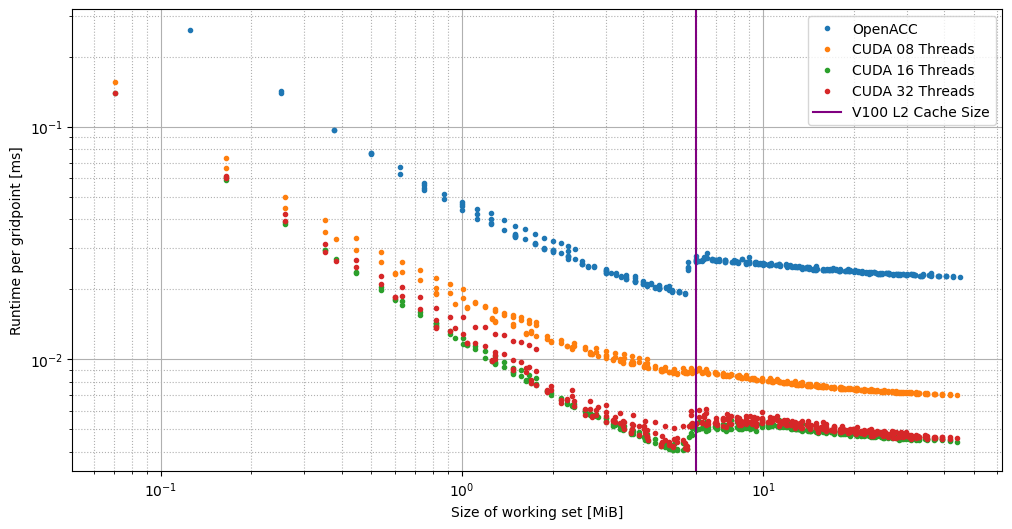

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.loglog(bench_oacc['workingset'], bench_oacc['rt_per_gp'], '.', label='OpenACC')

ax.loglog(bench_cuda_08['workingset'], bench_cuda_08['rt_per_gp'], '.', label='CUDA 08 Threads')
ax.loglog(bench_cuda_16['workingset'], bench_cuda_16['rt_per_gp'], '.', label='CUDA 16 Threads')
ax.loglog(bench_cuda_32['workingset'], bench_cuda_32['rt_per_gp'], '.', label='CUDA 32 Threads')

ax.axvline(6, color='purple', label='V100 L2 Cache Size')
ax.grid(which='major', linestyle='-')
ax.grid(which='minor', linestyle=':')
ax.set_xlabel('Size of working set [MiB]')
ax.set_ylabel('Runtime per gridpoint [ms]')
#ax.set_title('Runtime vs. Working Set Size')
ax.legend()
fig.savefig('./plot_optimized.png', bbox_inches='tight')

### Double plot
Optimized code with doubles instead of floats.

In [24]:
%%bash
ml -s nvhpc/23.3-gcc-11.3.0-fcnp4cv cuda11.7

CUFLAGS=-DTHREADS=8 make -C code clean stencil2d-cuda-double
./code/stencil2d-cuda-double --scan --nz 64 --num_iter 128 | grep -v ranks | sed 's/data = np.array(/pd.DataFrame(columns=["x","y","z","iter","time"], data =/' > ./data/bench_cuda_double08.txt
CUFLAGS=-DTHREADS=16 make -C code clean stencil2d-cuda-double
./code/stencil2d-cuda-double --scan --nz 64 --num_iter 128 | grep -v ranks | sed 's/data = np.array(/pd.DataFrame(columns=["x","y","z","iter","time"], data =/' > ./data/bench_cuda_double16.txt
CUFLAGS=-DTHREADS=32 make -C code clean stencil2d-cuda-double
./code/stencil2d-cuda-double --scan --nz 64 --num_iter 128 | grep -v ranks | sed 's/data = np.array(/pd.DataFrame(columns=["x","y","z","iter","time"], data =/' > ./data/bench_cuda_double32.txt

rm ./timing.dat

make: Entering directory '/home/fhoerold/mpc4wc/plots/code'
rm -f -rf *~ *.o *.mod       \
stencil2d-openacc            \
        stencil2d-cuda               \
        stencil2d-cuda-double        \
        stencil2d-cuda-thread-halo   \
        stencil2d-cuda-reduce-arrays \
        stencil2d-cuda-merge-kernels \
        stencil2d-cuda-basic
nvcc -DTHREADS=8 -O3 stencil2d-double.cu utils-double.cpp -o stencil2d-cuda-double
make: Leaving directory '/home/fhoerold/mpc4wc/plots/code'
make: Entering directory '/home/fhoerold/mpc4wc/plots/code'
rm -f -rf *~ *.o *.mod       \
stencil2d-openacc            \
        stencil2d-cuda               \
        stencil2d-cuda-double        \
        stencil2d-cuda-thread-halo   \
        stencil2d-cuda-reduce-arrays \
        stencil2d-cuda-merge-kernels \
        stencil2d-cuda-basic
nvcc -DTHREADS=16 -O3 stencil2d-double.cu utils-double.cpp -o stencil2d-cuda-double
make: Leaving directory '/home/fhoerold/mpc4wc/plots/code'
make: Entering director

In [25]:
bench_oacc = read_benchmark_file('./data/bench_openacc.txt')
add_derived_measures(bench_oacc)

bench_cuda_double_08 = read_benchmark_file('./data/bench_cuda_double08.txt')
bench_cuda_double_16 = read_benchmark_file('./data/bench_cuda_double16.txt')
bench_cuda_double_32 = read_benchmark_file('./data/bench_cuda_double32.txt')

add_derived_measures(bench_cuda_double_08, bytes_per_value=8)
add_derived_measures(bench_cuda_double_16, bytes_per_value=8)
add_derived_measures(bench_cuda_double_32, bytes_per_value=8)

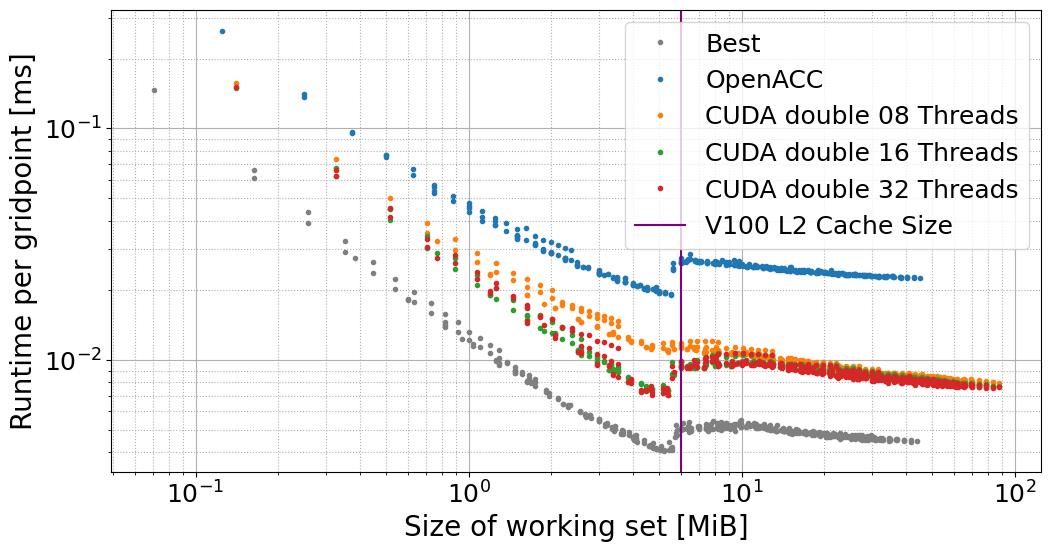

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))
# Add optimal for comparison
ax.loglog(bench_cuda_16['workingset'], bench_cuda_16['rt_per_gp'], '.', label='Best', color="grey")

ax.loglog(bench_oacc['workingset'], bench_oacc['rt_per_gp'], '.', label='OpenACC')

ax.loglog(bench_cuda_double_08['workingset'], bench_cuda_double_08['rt_per_gp'], '.', label='CUDA double 08 Threads')
ax.loglog(bench_cuda_double_16['workingset'], bench_cuda_double_16['rt_per_gp'], '.', label='CUDA double 16 Threads')
ax.loglog(bench_cuda_double_32['workingset'], bench_cuda_double_32['rt_per_gp'], '.', label='CUDA double 32 Threads')

ax.axvline(6, color='purple', label='V100 L2 Cache Size')
ax.grid(which='major', linestyle='-')
ax.grid(which='minor', linestyle=':')
ax.set_xlabel('Size of working set [MiB]')
ax.set_ylabel('Runtime per gridpoint [ms]')
#ax.set_title('Runtime vs. Working Set Size')
ax.legend()
fig.savefig('./plot_double.png', bbox_inches='tight')

### Threaded halos
Compute halos with threads instead of blocks.

In [27]:
%%bash
ml -s nvhpc/23.3-gcc-11.3.0-fcnp4cv cuda11.7

CUFLAGS=-DTHREADS=8 make -C code clean stencil2d-cuda-thread-halo
./code/stencil2d-cuda-thread-halo --scan --nz 64 --num_iter 128 | grep -v ranks | sed 's/data = np.array(/pd.DataFrame(columns=["x","y","z","iter","time"], data =/' > ./data/bench_cuda_thread_halo08.txt
CUFLAGS=-DTHREADS=16 make -C code clean stencil2d-cuda-thread-halo
./code/stencil2d-cuda-thread-halo --scan --nz 64 --num_iter 128 | grep -v ranks | sed 's/data = np.array(/pd.DataFrame(columns=["x","y","z","iter","time"], data =/' > ./data/bench_cuda_thread_halo16.txt
CUFLAGS=-DTHREADS=32 make -C code clean stencil2d-cuda-thread-halo
./code/stencil2d-cuda-thread-halo --scan --nz 64 --num_iter 128 | grep -v ranks | sed 's/data = np.array(/pd.DataFrame(columns=["x","y","z","iter","time"], data =/' > ./data/bench_cuda_thread_halo32.txt

rm ./timing.dat

make: Entering directory '/home/fhoerold/mpc4wc/plots/code'
rm -f -rf *~ *.o *.mod       \
stencil2d-openacc            \
        stencil2d-cuda               \
        stencil2d-cuda-double        \
        stencil2d-cuda-thread-halo   \
        stencil2d-cuda-reduce-arrays \
        stencil2d-cuda-merge-kernels \
        stencil2d-cuda-basic
nvcc -DTHREADS=8 -O3 stencil2d-thread-halo.cu utils.cpp -o stencil2d-cuda-thread-halo
make: Leaving directory '/home/fhoerold/mpc4wc/plots/code'
make: Entering directory '/home/fhoerold/mpc4wc/plots/code'
rm -f -rf *~ *.o *.mod       \
stencil2d-openacc            \
        stencil2d-cuda               \
        stencil2d-cuda-double        \
        stencil2d-cuda-thread-halo   \
        stencil2d-cuda-reduce-arrays \
        stencil2d-cuda-merge-kernels \
        stencil2d-cuda-basic
nvcc -DTHREADS=16 -O3 stencil2d-thread-halo.cu utils.cpp -o stencil2d-cuda-thread-halo
make: Leaving directory '/home/fhoerold/mpc4wc/plots/code'
make: Entering di

In [28]:
bench_oacc = read_benchmark_file('./data/bench_openacc.txt')
add_derived_measures(bench_oacc)

bench_cuda_thread_halo_08 = read_benchmark_file('./data/bench_cuda_thread_halo08.txt')
bench_cuda_thread_halo_16 = read_benchmark_file('./data/bench_cuda_thread_halo16.txt')
bench_cuda_thread_halo_32 = read_benchmark_file('./data/bench_cuda_thread_halo32.txt')

add_derived_measures(bench_cuda_thread_halo_08)
add_derived_measures(bench_cuda_thread_halo_16)
add_derived_measures(bench_cuda_thread_halo_32)

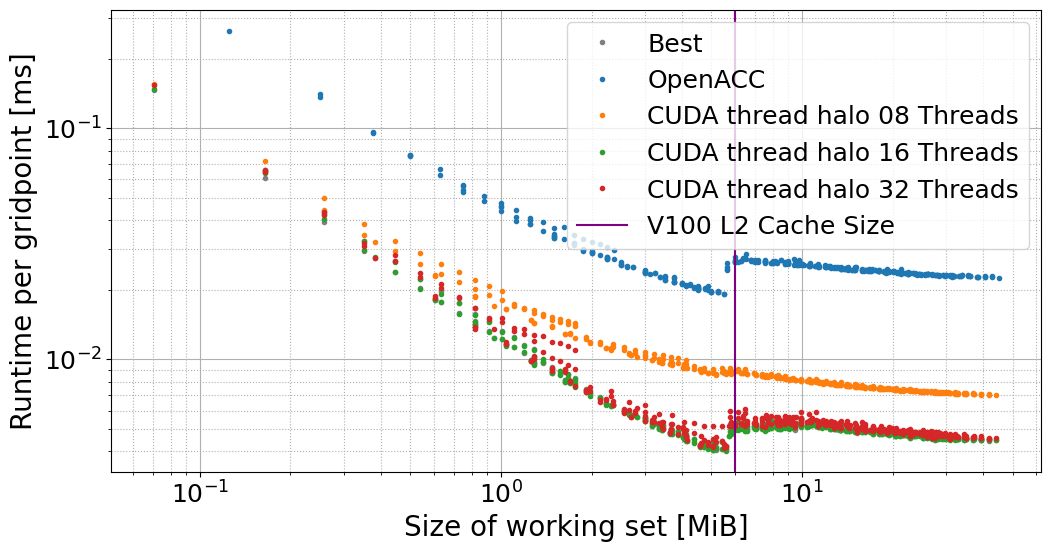

In [29]:
fig, ax = plt.subplots(figsize=(12, 6))
# Add optimal for comparison
ax.loglog(bench_cuda_16['workingset'], bench_cuda_16['rt_per_gp'], '.', label='Best', color="grey")

ax.loglog(bench_oacc['workingset'], bench_oacc['rt_per_gp'], '.', label='OpenACC')

ax.loglog(bench_cuda_thread_halo_08['workingset'], bench_cuda_thread_halo_08['rt_per_gp'], '.', label='CUDA thread halo 08 Threads')
ax.loglog(bench_cuda_thread_halo_16['workingset'], bench_cuda_thread_halo_16['rt_per_gp'], '.', label='CUDA thread halo 16 Threads')
ax.loglog(bench_cuda_thread_halo_32['workingset'], bench_cuda_thread_halo_32['rt_per_gp'], '.', label='CUDA thread halo 32 Threads')

ax.axvline(6, color='purple', label='V100 L2 Cache Size')
ax.grid(which='major', linestyle='-')
ax.grid(which='minor', linestyle=':')
ax.set_xlabel('Size of working set [MiB]')
ax.set_ylabel('Runtime per gridpoint [ms]')
#ax.set_title('Runtime vs. Working Set Size')
ax.legend()
fig.savefig('./plot_thread_halo.png', bbox_inches='tight')

### Reduce arrays
Remove unnecessary array.

In [30]:
%%bash
ml -s nvhpc/23.3-gcc-11.3.0-fcnp4cv cuda11.7

CUFLAGS=-DTHREADS=8 make -C code clean stencil2d-cuda-reduce-arrays
./code/stencil2d-cuda-reduce-arrays --scan --nz 64 --num_iter 128 | grep -v ranks | sed 's/data = np.array(/pd.DataFrame(columns=["x","y","z","iter","time"], data =/' > ./data/bench_cuda_reduce_arrays08.txt
CUFLAGS=-DTHREADS=16 make -C code clean stencil2d-cuda-reduce-arrays
./code/stencil2d-cuda-reduce-arrays --scan --nz 64 --num_iter 128 | grep -v ranks | sed 's/data = np.array(/pd.DataFrame(columns=["x","y","z","iter","time"], data =/' > ./data/bench_cuda_reduce_arrays16.txt
CUFLAGS=-DTHREADS=32 make -C code clean stencil2d-cuda-reduce-arrays
./code/stencil2d-cuda-reduce-arrays --scan --nz 64 --num_iter 128 | grep -v ranks | sed 's/data = np.array(/pd.DataFrame(columns=["x","y","z","iter","time"], data =/' > ./data/bench_cuda_reduce_arrays32.txt

rm ./timing.dat

make: Entering directory '/home/fhoerold/mpc4wc/plots/code'
rm -f -rf *~ *.o *.mod       \
stencil2d-openacc            \
        stencil2d-cuda               \
        stencil2d-cuda-double        \
        stencil2d-cuda-thread-halo   \
        stencil2d-cuda-reduce-arrays \
        stencil2d-cuda-merge-kernels \
        stencil2d-cuda-basic
nvcc -DTHREADS=8 -O3 stencil2d-reduce-arrays.cu utils.cpp -o stencil2d-cuda-reduce-arrays
make: Leaving directory '/home/fhoerold/mpc4wc/plots/code'
make: Entering directory '/home/fhoerold/mpc4wc/plots/code'
rm -f -rf *~ *.o *.mod       \
stencil2d-openacc            \
        stencil2d-cuda               \
        stencil2d-cuda-double        \
        stencil2d-cuda-thread-halo   \
        stencil2d-cuda-reduce-arrays \
        stencil2d-cuda-merge-kernels \
        stencil2d-cuda-basic
nvcc -DTHREADS=16 -O3 stencil2d-reduce-arrays.cu utils.cpp -o stencil2d-cuda-reduce-arrays
make: Leaving directory '/home/fhoerold/mpc4wc/plots/code'
make: Ent

In [31]:
bench_oacc = read_benchmark_file('./data/bench_openacc.txt')
add_derived_measures(bench_oacc)

bench_cuda_reduce_arrays_08 = read_benchmark_file('./data/bench_cuda_reduce_arrays08.txt')
bench_cuda_reduce_arrays_16 = read_benchmark_file('./data/bench_cuda_reduce_arrays16.txt')
bench_cuda_reduce_arrays_32 = read_benchmark_file('./data/bench_cuda_reduce_arrays32.txt')

add_derived_measures(bench_cuda_reduce_arrays_08)
add_derived_measures(bench_cuda_reduce_arrays_16)
add_derived_measures(bench_cuda_reduce_arrays_32)

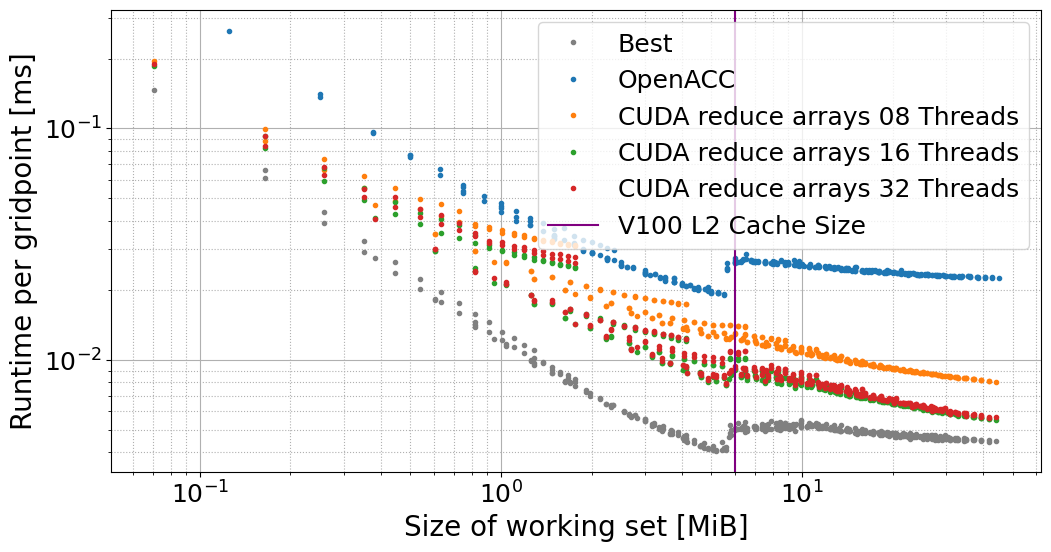

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))
# Add optimal for comparison
ax.loglog(bench_cuda_16['workingset'], bench_cuda_16['rt_per_gp'], '.', label='Best', color="grey")

ax.loglog(bench_oacc['workingset'], bench_oacc['rt_per_gp'], '.', label='OpenACC')

ax.loglog(bench_cuda_reduce_arrays_08['workingset'], bench_cuda_reduce_arrays_08['rt_per_gp'], '.', label='CUDA reduce arrays 08 Threads')
ax.loglog(bench_cuda_reduce_arrays_16['workingset'], bench_cuda_reduce_arrays_16['rt_per_gp'], '.', label='CUDA reduce arrays 16 Threads')
ax.loglog(bench_cuda_reduce_arrays_32['workingset'], bench_cuda_reduce_arrays_32['rt_per_gp'], '.', label='CUDA reduce arrays 32 Threads')

ax.axvline(6, color='purple', label='V100 L2 Cache Size')
ax.grid(which='major', linestyle='-')
ax.grid(which='minor', linestyle=':')
ax.set_xlabel('Size of working set [MiB]')
ax.set_ylabel('Runtime per gridpoint [ms]')
#ax.set_title('Runtime vs. Working Set Size')
ax.legend()
fig.savefig('./plot_reduce_arrays.png', bbox_inches='tight')

### Merge kernels
Merge second Laplacian with Euler step

In [33]:
%%bash
ml -s nvhpc/23.3-gcc-11.3.0-fcnp4cv cuda11.7

CUFLAGS=-DTHREADS=8 make -C code clean stencil2d-cuda-merge-kernels
./code/stencil2d-cuda-merge-kernels --scan --nz 64 --num_iter 128 | grep -v ranks | sed 's/data = np.array(/pd.DataFrame(columns=["x","y","z","iter","time"], data =/' > ./data/bench_cuda_merge_kernels08.txt
CUFLAGS=-DTHREADS=16 make -C code clean stencil2d-cuda-merge-kernels
./code/stencil2d-cuda-merge-kernels --scan --nz 64 --num_iter 128 | grep -v ranks | sed 's/data = np.array(/pd.DataFrame(columns=["x","y","z","iter","time"], data =/' > ./data/bench_cuda_merge_kernels16.txt
CUFLAGS=-DTHREADS=32 make -C code clean stencil2d-cuda-merge-kernels
./code/stencil2d-cuda-merge-kernels --scan --nz 64 --num_iter 128 | grep -v ranks | sed 's/data = np.array(/pd.DataFrame(columns=["x","y","z","iter","time"], data =/' > ./data/bench_cuda_merge_kernels32.txt

rm ./timing.dat

make: Entering directory '/home/fhoerold/mpc4wc/plots/code'
rm -f -rf *~ *.o *.mod       \
stencil2d-openacc            \
        stencil2d-cuda               \
        stencil2d-cuda-double        \
        stencil2d-cuda-thread-halo   \
        stencil2d-cuda-reduce-arrays \
        stencil2d-cuda-merge-kernels \
        stencil2d-cuda-basic
nvcc -DTHREADS=8 -O3 stencil2d-merge-kernels.cu utils.cpp -o stencil2d-cuda-merge-kernels
make: Leaving directory '/home/fhoerold/mpc4wc/plots/code'
make: Entering directory '/home/fhoerold/mpc4wc/plots/code'
rm -f -rf *~ *.o *.mod       \
stencil2d-openacc            \
        stencil2d-cuda               \
        stencil2d-cuda-double        \
        stencil2d-cuda-thread-halo   \
        stencil2d-cuda-reduce-arrays \
        stencil2d-cuda-merge-kernels \
        stencil2d-cuda-basic
nvcc -DTHREADS=16 -O3 stencil2d-merge-kernels.cu utils.cpp -o stencil2d-cuda-merge-kernels
make: Leaving directory '/home/fhoerold/mpc4wc/plots/code'
make: Ent

In [34]:
bench_oacc = read_benchmark_file('./data/bench_openacc.txt')
add_derived_measures(bench_oacc)

bench_cuda_merge_kernels_08 = read_benchmark_file('./data/bench_cuda_merge_kernels08.txt')
bench_cuda_merge_kernels_16 = read_benchmark_file('./data/bench_cuda_merge_kernels16.txt')
bench_cuda_merge_kernels_32 = read_benchmark_file('./data/bench_cuda_merge_kernels32.txt')

add_derived_measures(bench_cuda_merge_kernels_08)
add_derived_measures(bench_cuda_merge_kernels_16)
add_derived_measures(bench_cuda_merge_kernels_32)

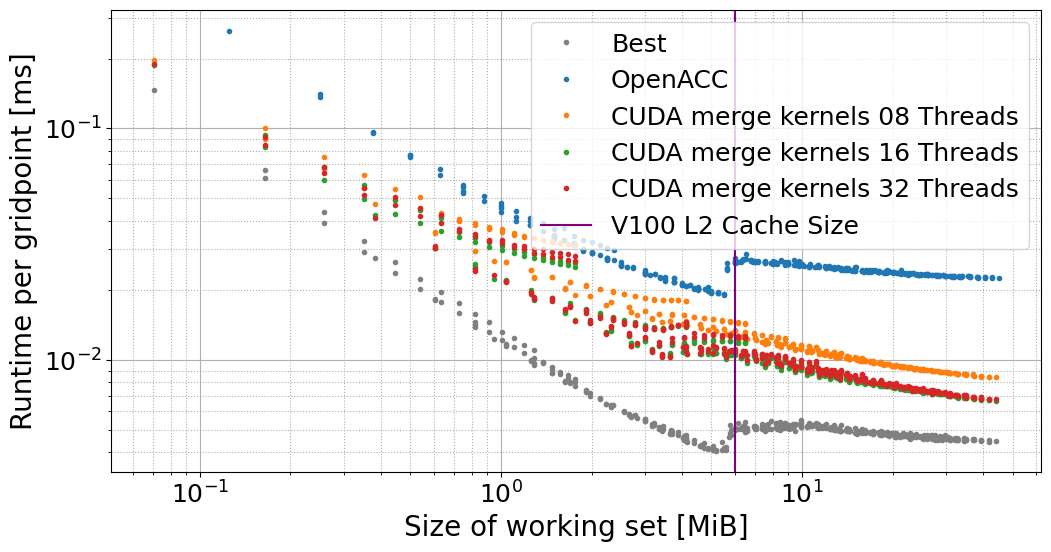

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))
# Add optimal for comparison
ax.loglog(bench_cuda_16['workingset'], bench_cuda_16['rt_per_gp'], '.', label='Best', color="grey")

ax.loglog(bench_oacc['workingset'], bench_oacc['rt_per_gp'], '.', label='OpenACC')

ax.loglog(bench_cuda_merge_kernels_08['workingset'], bench_cuda_merge_kernels_08['rt_per_gp'], '.', label='CUDA merge kernels 08 Threads')
ax.loglog(bench_cuda_merge_kernels_16['workingset'], bench_cuda_merge_kernels_16['rt_per_gp'], '.', label='CUDA merge kernels 16 Threads')
ax.loglog(bench_cuda_merge_kernels_32['workingset'], bench_cuda_merge_kernels_32['rt_per_gp'], '.', label='CUDA merge kernels 32 Threads')

ax.axvline(6, color='purple', label='V100 L2 Cache Size')
ax.grid(which='major', linestyle='-')
ax.grid(which='minor', linestyle=':')
ax.set_xlabel('Size of working set [MiB]')
ax.set_ylabel('Runtime per gridpoint [ms]')
#ax.set_title('Runtime vs. Working Set Size')
ax.legend()
fig.savefig('./plot_merge_kernels.png', bbox_inches='tight')

### Basic implementation

In [36]:
%%bash
ml -s nvhpc/23.3-gcc-11.3.0-fcnp4cv cuda11.7

CUFLAGS=-DTHREADS=8 make -C code clean stencil2d-cuda-basic
./code/stencil2d-cuda-basic --scan --nz 64 --num_iter 128 | grep -v ranks | sed 's/data = np.array(/pd.DataFrame(columns=["x","y","z","iter","time"], data =/' > ./data/bench_cuda_basic08.txt
CUFLAGS=-DTHREADS=16 make -C code clean stencil2d-cuda-basic
./code/stencil2d-cuda-basic --scan --nz 64 --num_iter 128 | grep -v ranks | sed 's/data = np.array(/pd.DataFrame(columns=["x","y","z","iter","time"], data =/' > ./data/bench_cuda_basic16.txt
CUFLAGS=-DTHREADS=32 make -C code clean stencil2d-cuda-basic
./code/stencil2d-cuda-basic --scan --nz 64 --num_iter 128 | grep -v ranks | sed 's/data = np.array(/pd.DataFrame(columns=["x","y","z","iter","time"], data =/' > ./data/bench_cuda_basic32.txt

rm ./timing.dat

make: Entering directory '/home/fhoerold/mpc4wc/plots/code'
rm -f -rf *~ *.o *.mod       \
stencil2d-openacc            \
        stencil2d-cuda               \
        stencil2d-cuda-double        \
        stencil2d-cuda-thread-halo   \
        stencil2d-cuda-reduce-arrays \
        stencil2d-cuda-merge-kernels \
        stencil2d-cuda-basic
nvcc -DTHREADS=8 -O3 stencil2d-basic.cu utils.cpp -o stencil2d-cuda-basic
make: Leaving directory '/home/fhoerold/mpc4wc/plots/code'
make: Entering directory '/home/fhoerold/mpc4wc/plots/code'
rm -f -rf *~ *.o *.mod       \
stencil2d-openacc            \
        stencil2d-cuda               \
        stencil2d-cuda-double        \
        stencil2d-cuda-thread-halo   \
        stencil2d-cuda-reduce-arrays \
        stencil2d-cuda-merge-kernels \
        stencil2d-cuda-basic
nvcc -DTHREADS=16 -O3 stencil2d-basic.cu utils.cpp -o stencil2d-cuda-basic
make: Leaving directory '/home/fhoerold/mpc4wc/plots/code'
make: Entering directory '/home/fhoerold/

In [37]:
bench_oacc = read_benchmark_file('./data/bench_openacc.txt')
add_derived_measures(bench_oacc)

bench_cuda_basic_08 = read_benchmark_file('./data/bench_cuda_basic08.txt')
bench_cuda_basic_16 = read_benchmark_file('./data/bench_cuda_basic16.txt')
bench_cuda_basic_32 = read_benchmark_file('./data/bench_cuda_basic32.txt')

add_derived_measures(bench_cuda_basic_08)
add_derived_measures(bench_cuda_basic_16)
add_derived_measures(bench_cuda_basic_32)

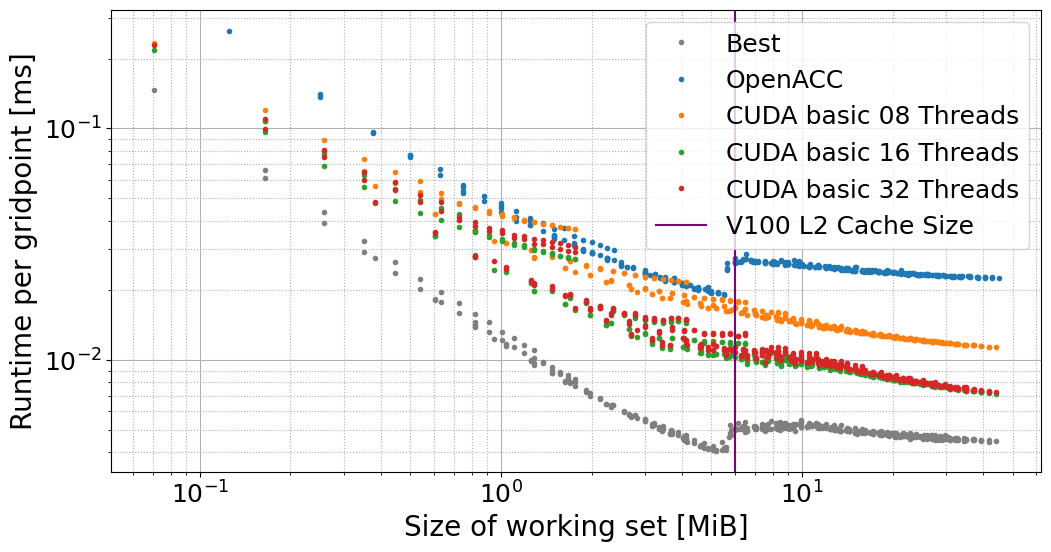

In [38]:
fig, ax = plt.subplots(figsize=(12, 6))
# Add optimal for comparison
ax.loglog(bench_cuda_16['workingset'], bench_cuda_16['rt_per_gp'], '.', label='Best', color="grey")

ax.loglog(bench_oacc['workingset'], bench_oacc['rt_per_gp'], '.', label='OpenACC')

ax.loglog(bench_cuda_basic_08['workingset'], bench_cuda_basic_08['rt_per_gp'], '.', label='CUDA basic 08 Threads')
ax.loglog(bench_cuda_basic_16['workingset'], bench_cuda_basic_16['rt_per_gp'], '.', label='CUDA basic 16 Threads')
ax.loglog(bench_cuda_basic_32['workingset'], bench_cuda_basic_32['rt_per_gp'], '.', label='CUDA basic 32 Threads')

ax.axvline(6, color='purple', label='V100 L2 Cache Size')
ax.grid(which='major', linestyle='-')
ax.grid(which='minor', linestyle=':')
ax.set_xlabel('Size of working set [MiB]')
ax.set_ylabel('Runtime per gridpoint [ms]')
#ax.set_title('Runtime vs. Working Set Size')
ax.legend()
fig.savefig('./plot_basic.png', bbox_inches='tight')

### Shared memory

In [15]:
%%bash
ml -s nvhpc/23.3-gcc-11.3.0-fcnp4cv

nvcc --generate-line-info -O3 -c ../thomas/cpp/stencil2d_kernels.cu ../thomas/cpp/stencil2d_occupancy.cu
nvcc -O3 ../thomas/cpp/stencil2d_common.cpp ../thomas/cpp/stencil2d_cuda.cpp ../thomas/cpp/stencil2d_host.cpp ../thomas/cpp/stencil2d_main.cpp stencil2d_kernels.o stencil2d_occupancy.o -o stencil2d.x

./stencil2d.x -s -z64 -i128 -r3 -b4 > ./data/bench_cuda_shared04.txt
./stencil2d.x -s -z64 -i128 -r3 -b12 > ./data/bench_cuda_shared12.txt
./stencil2d.x -s -z64 -i128 -r3 -b28 > ./data/bench_cuda_shared28.txt

In [16]:
bench_oacc = read_benchmark_file('./data/bench_openacc.txt')
add_derived_measures(bench_oacc)

bench_cuda_shared_04 = read_benchmark_file('./data/bench_cuda_shared04.txt')
bench_cuda_shared_12 = read_benchmark_file('./data/bench_cuda_shared12.txt')
bench_cuda_shared_28 = read_benchmark_file('./data/bench_cuda_shared28.txt')

add_derived_measures(bench_cuda_shared_04)
add_derived_measures(bench_cuda_shared_12)
add_derived_measures(bench_cuda_shared_28)

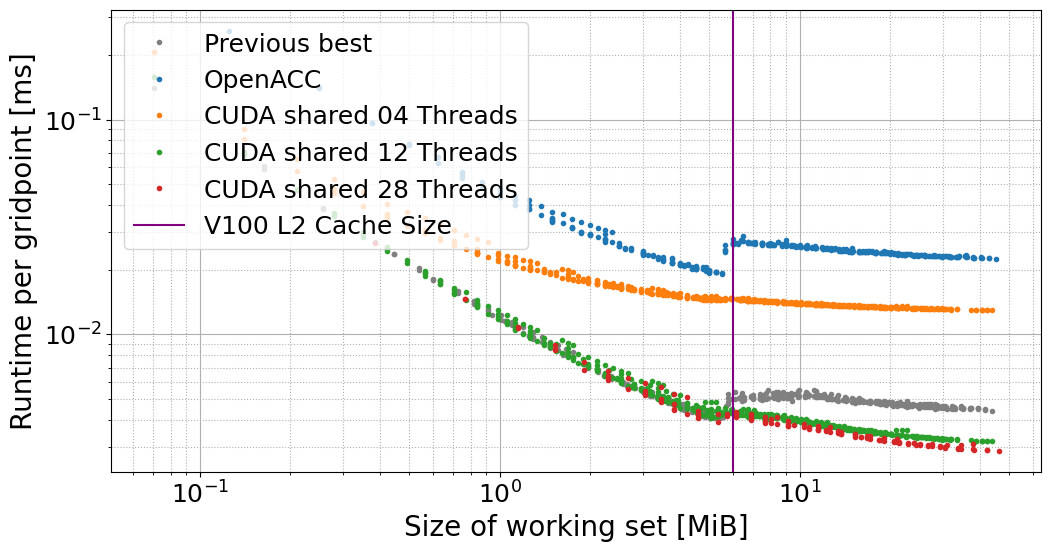

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.loglog(bench_cuda_16['workingset'], bench_cuda_16['rt_per_gp'], '.', label='Previous best', color="grey")

ax.loglog(bench_oacc['workingset'], bench_oacc['rt_per_gp'], '.', label='OpenACC')

ax.loglog(bench_cuda_shared_04['workingset'], bench_cuda_shared_04['rt_per_gp'], '.', label='CUDA shared 04 Threads')
ax.loglog(bench_cuda_shared_12['workingset'], bench_cuda_shared_12['rt_per_gp'], '.', label='CUDA shared 12 Threads')
ax.loglog(bench_cuda_shared_28['workingset'], bench_cuda_shared_28['rt_per_gp'], '.', label='CUDA shared 28 Threads')

ax.axvline(6, color='purple', label='V100 L2 Cache Size')
ax.grid(which='major', linestyle='-')
ax.grid(which='minor', linestyle=':')
ax.set_xlabel('Size of working set [MiB]')
ax.set_ylabel('Runtime per gridpoint [ms]')
#ax.set_title('Runtime vs. Working Set Size')
ax.legend()
fig.savefig('./plot_shared.png', bbox_inches='tight')

### Profiler Pie plot
Remake the Pie plot from the profiler with bigger text.

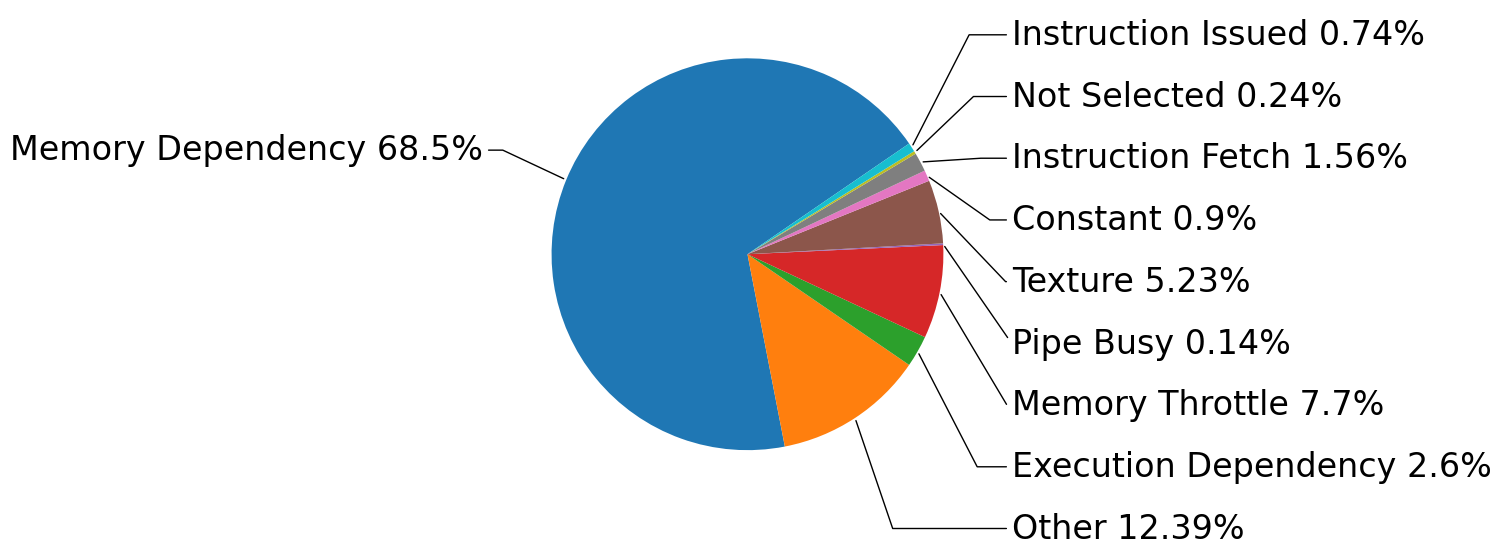

In [11]:
noshared_fractions = [68.5, 12.39, 2.6, 7.7, 0.14, 5.23, 0.9, 1.56, 0.24, 0.74]
noshared_labels = ['Memory Dependency', 'Other', 'Execution Dependency', 'Memory Throttle', 'Pipe Busy', 'Texture', 'Constant', 'Instruction Fetch', 'Not Selected', 'Instruction Issued']
shared_fractions = [30.17, 10.86, 28.64, 0.79, 0.84, 0.8, 3.29, 3.33, 3.18, 18.11]
shared_labels = ['Memory Dependency', 'Other', 'Execution Dependency', 'Memory Throttle', 'Pipe Busy', 'Constant', 'Instruction Fetch', 'Not Selected', 'Instruction Issued', 'Synchronization']


fig, ax = plt.subplots(figsize=(12, 6))

kw = dict(arrowprops=dict(arrowstyle="-"), zorder=0, va="center", fontsize=24)

wedges, texts = ax.pie(noshared_fractions, startangle = 180 - sum(noshared_fractions[:2]) * 3.6 / 2.0)
positions = []
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    positions.append([ang, x, x, y, y])
        
positions[9][4] =  0.800
positions[8][4] =  0.575
positions[7][4] =  0.350
positions[6][4] =  0.125
positions[5][4] = -0.100
positions[4][4] = -0.325
positions[3][4] = -0.550
positions[2][4] = -0.775
positions[1][4] = -1.000
        
for i, p in enumerate(positions):
    ang = p[0]
    x = p[1]
    x2 = p[2]
    y = p[3]
    y2 = p[4]
    
    dx = 1.35 * x2 - x
    dy = 1.4 * y2 - y
    ang2 = np.rad2deg(np.arctan2(dy, dx))
    
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x2))]
    connectionstyle = f"angle,angleA=0,angleB={ang2}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(noshared_labels[i] + " " + str(noshared_fractions[i]) + "%", xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y2),
                    horizontalalignment=horizontalalignment, **kw)

#ax.set_title("Global memory")
fig.tight_layout()
fig.savefig('./pie1.png', bbox_inches='tight')

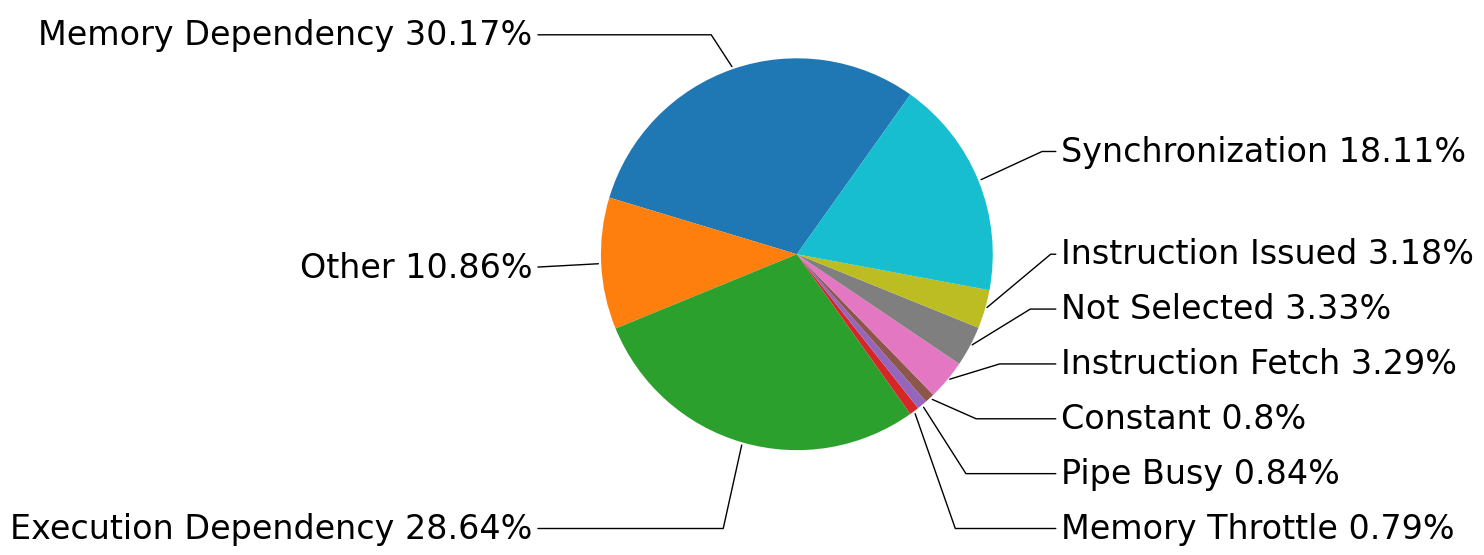

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))

wedges, texts = ax.pie(shared_fractions, startangle = 180 - sum(shared_fractions[:3]) * 3.6 / 2.0)
positions = []
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    positions.append([ang, x, x, y, y])
        
positions[0][4] = 0.8
positions[2][4] = -1.0
positions[3][4] = -1.0
positions[4][4] = -0.8
positions[5][4] = -0.6
positions[6][4] = -0.4
positions[7][4] = -0.2
positions[8][4] = 0.0

        
for i, p in enumerate(positions):
    ang = p[0]
    x = p[1]
    x2 = p[2]
    y = p[3]
    y2 = p[4]
    
    dx = 1.35 * x2 - x
    dy = 1.4 * y2 - y
    ang2 = np.rad2deg(np.arctan2(dy, dx))
    
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x2))]
    connectionstyle = f"angle,angleA=0,angleB={ang2}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(shared_labels[i] + " " + str(shared_fractions[i]) + "%", xy=(x, y), xytext=(1.35*np.sign(x2), 1.4*y2),
                    horizontalalignment=horizontalalignment, **kw) 



#ax.set_title("Shared memory")
fig.tight_layout()
fig.savefig('./pie2.png', bbox_inches='tight')